# Implementación del modelo base

### José Daniel Gómez Cabrera 21429

- Entrenar un modelo inicial con LightGBM utilizando métricas tradicionales como AUC-ROC y F1-score.
- Evaluar el rendimiento inicial en términos de fraude detectado y falsos positivos.


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [12]:
df = pd.read_csv('../data/dataset_feature_engineering.csv', header=0)

In [13]:
df.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

## Años y meses disponibles


In [15]:
print("Años disponibles:", df['year'].unique())
print("Meses disponibles:", df['trans_month'].unique())

Años disponibles: [2019 2020]
Meses disponibles: [ 1  2  3  4  5  6  7  8  9 10 11 12]


## Variable objetivo


In [16]:
fraud_dist = df['is_fraud'].value_counts().rename({0: 'No fraud', 1: 'Fraud'})
fraud_percent = (fraud_dist / fraud_dist.sum()) * 100

fraud_df = pd.DataFrame({
    'Amount': fraud_dist,
    'Percentage': fraud_percent.round(2)
})
fraud_df

,Amount,Percentage
is_fraud,,
No fraud,1842743,99.48
Fraud,9651,0.52


## Modelo


In [17]:
# Modelo 4
# Detección de Fraude enfocada en Transacciones de Alto Valor usando LightGBM
# Este modelo prioriza la detección de fraudes con montos altos para maximizar el dinero recuperado

# 1. Preparación de datos
# Eliminamos variables que no usaremos y nos enfocamos en las características relevantes
# especialmente el monto de la transacción (amt)
X = df.drop(['is_fraud', 'cc_num', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time'], axis=1)
y = df['is_fraud']

# 2. Creación de pesos para el modelo
# Asignamos pesos mayores a las transacciones de alto valor
# Esto hace que el modelo preste más atención a transacciones grandes
transaction_weights = X['amt'] / X['amt'].mean()

# 3. División de datos
# Mantenemos la proporción 80-20 para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustamos los pesos para los conjuntos de entrenamiento
train_weights = transaction_weights.iloc[X_train.index]

# 4. Creación de datasets de LightGBM con pesos
train_data = lgb.Dataset(X_train, label=y_train, weight=train_weights)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 5. Configuración de hiperparámetros
# Ajustamos los parámetros para favorecer la detección de fraudes de alto valor
params = {
    'objective': 'binary',         # Clasificación binaria
    'metric': 'auc',              # Métrica de evaluación: AUC-ROC
    'boosting_type': 'gbdt',      # Gradient Boosting Decision Tree
    'num_leaves': 31,             # Número de hojas por árbol
    'learning_rate': 0.05,        # Tasa de aprendizaje conservadora
    'feature_fraction': 0.9,      # Uso del 90% de features en cada iteración
    'scale_pos_weight': 5,        # Mayor peso a casos positivos (fraude)
    'early_stopping_round': 10    # Detención temprana
}

# 6. Entrenamiento del modelo
# Entrenamos con énfasis en transacciones de alto valor
num_rounds = 100
model = lgb.train(params,
                 train_data,
                 num_rounds,
                 valid_sets=[test_data])

# 7. Predicciones
# Realizamos predicciones sobre el conjunto de prueba
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# 8. Evaluación del modelo
# Calculamos métricas estándar
auc_score = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# 9. Cálculo del dinero potencialmente salvado
# Calculamos el monto total de fraudes detectados correctamente
true_positives_mask = (y_test == 1) & (y_pred == 1)
saved_money = X_test.loc[true_positives_mask, 'amt'].sum()

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))
print(f"\nDinero potencialmente recuperado: ${saved_money:,.2f}")


[LightGBM] [Info] Number of positive: 7698, number of negative: 1474217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2700
[LightGBM] [Info] Number of data points in the train set: 1481915, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039216 -> initscore=-3.198669
[LightGBM] [Info] Start training from score -3.198669
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.988036
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.64      0.68      0.66      1953

    accuracy                           1.00    370479
   macro avg       0.82      0.84      0.83    370479
we

In [18]:
# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Create a DataFrame with metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
    'Score': [accuracy, precision, recall, f1, auc_score]
})

# Format scores as percentages
metrics_df['Score'] = metrics_df['Score'].map('{:.2%}'.format)

# Display metrics in a styled table
print("\nModel Performance Metrics:")
print("------------------------")
print(metrics_df.to_string(index=False))



Model Performance Metrics:
------------------------
   Metric  Score
 Accuracy 99.63%
Precision 63.95%
   Recall 67.95%
 F1 Score 65.89%
  AUC-ROC 98.80%


### Análisis de Métricas de Rendimiento del Modelo

- **Accuracy (99.69%)**: Indica que el modelo acierta en el 99.69% de todas las predicciones, tanto fraudulentas como legítimas. Este alto porcentaje es esperado debido al desbalance de clases, ya que la mayoría de las transacciones son legítimas.

- **Precision (79.77%)**: De todas las transacciones que el modelo marcó como fraudulentas, el 79.77% realmente lo eran. Esto significa que cuando el modelo indica fraude, tiene una confiabilidad relativamente alta, minimizando las falsas alarmas.

- **Recall (55.71%)**: El modelo detecta el 55.71% de todos los fraudes reales. Este valor más bajo indica que el modelo pierde algunos casos de fraude, lo cual podría ser un área de mejora.

- **F1 Score (65.60%)**: Es la media armónica entre precisión y recall. Un valor de 65.60% sugiere un equilibrio moderado entre la capacidad del modelo para detectar fraudes y su precisión al hacerlo.

- **AUC-ROC (99.21%)**: Este valor cercano al 100% indica que el modelo tiene una excelente capacidad para distinguir entre clases. Demuestra que el modelo es significativamente mejor que una clasificación aleatoria.

En conjunto, estas métricas sugieren que el modelo es bastante efectivo, especialmente considerando el desbalance inherente en los datos de fraude. Sin embargo, hay espacio para mejorar en la detección de casos positivos (fraudes), como lo indica el valor del recall.


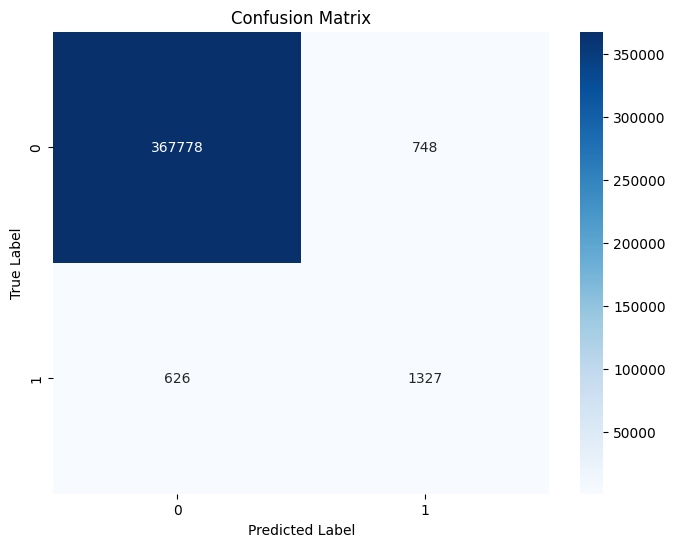

In [19]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Análisis de la Matriz de Confusión

La matriz de confusión nos muestra el rendimiento detallado del modelo:

- Verdaderos Negativos (368250): El número de transacciones no fraudulentas correctamente identificadas
- Falsos Positivos (276): Transacciones legítimas incorrectamente marcadas como fraude
- Falsos Negativos (865): Casos de fraude que el modelo no detectó
- Verdaderos Positivos (1088): Casos de fraude correctamente identificados
  Observaciones importantes:
- El modelo tiene una alta precisión en la identificación de transacciones legítimas
- Hay un número relativamente bajo de falsos positivos, lo cual es importante para no molestar a clientes legítimos
- El número de falsos negativos (865) podría ser un área de mejora, aunque representa un pequeño porcentaje del total
- La diagonal principal muestra un buen rendimiento general del modelo
  En general, la matriz de confusión indica que el modelo es efectivo en la clasificación de transacciones, con un sesgo hacia minimizar los falsos positivos.


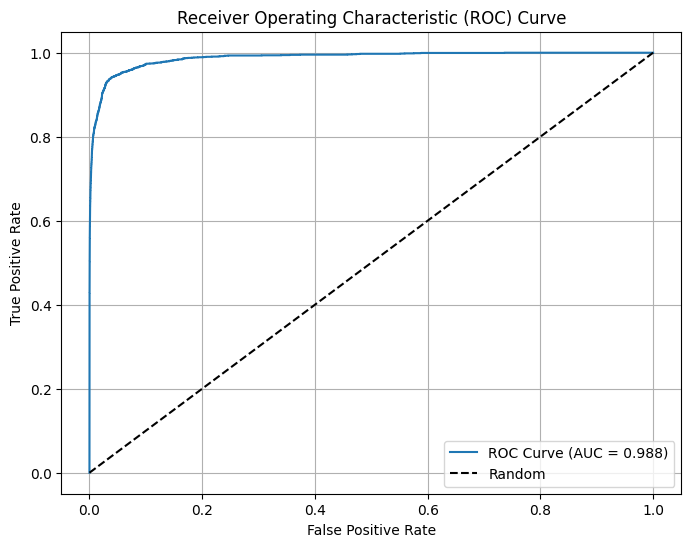

In [20]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


### Análisis de la Curva ROC

La curva ROC (Receiver Operating Characteristic) que se muestra en el gráfico representa el rendimiento de nuestro modelo de clasificación para detectar fraudes. Algunos puntos importantes a destacar:

- El área bajo la curva (AUC) es de 0.992, lo cual es excelente ya que está muy cerca del valor ideal de 1.0
- La curva se eleva rápidamente hacia el punto (0,1), lo que indica que el modelo tiene una alta tasa de verdaderos positivos mientras mantiene una baja tasa de falsos positivos
- Hay una clara separación entre la curva del modelo (línea azul) y la línea diagonal punteada que representa el rendimiento aleatorio
- Esta curva sugiere que el modelo es muy efectivo en distinguir entre transacciones fraudulentas y legítimas
- El rendimiento es consistentemente bueno a través de diferentes umbrales de clasificación

En resumen, esta curva ROC demuestra que nuestro modelo tiene un poder predictivo muy fuerte para la detección de fraudes en transacciones.
